# Project Proposal
Group 60 - Danyal, Ruth, Thomas, Paul

## Title: Predicting Heart disease based on data

## Introduction (Ruth)    

   Heart disease commonly refers to a reduced blood flow to the heart due to narrowed vessels. The most common heart disease is known as Coronoary Artery Disease (CAD) where cholesterol deposits of plaque buildup in the wall of the arteries [1]. When the heart does not recieve enough oxygen-rich blood, it becomes deprived of nutrients and reduces it's ability to pump blood out of the aorta. Symptoms of reduced blood flow lead shortness of breath, chest pain, and eventually heart attacks [2]. Therefore, the question we can formulate is: **Can we use the heart disease data containing the different attributes of each patient to predict whethere a future patient with certain attributes shows a diameter narrowing of <50% or >50%?**
   
   The heart dataset we will be using to explore this question in a multivariate data set with 75 attributes. Out of those 75, we have chosen 13 attribute that will be the predictors for the classification of the last attribute. The last attribute will predict a value of 0 or 1 where Value 0: < 50% diameter narrowing and Value 1: > 50% diameter narrowing

## Preliminary exploratory data analysis (Thomas)
Notes:
* Although all of these variables appear numeric in the data files, the documentation tells us that many of them are actually categorical. We have only been shown how to deal with numeric variables, so we will either have to wait for more explanation in class or omit the categorical variables from our model.
* Following the lead of the previous experiments mentioned on the website, I used only the reduced datasets with 14 columns. I also combined the values from 1 to 4 for different diagnoses into a simple "true" value in a new column, and dropped the original column. Unlike the previous experiments, however, I combined the data from all 4 locations into one table, keeping track of the locations in another new column.

In [1]:
# Setup
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(9248)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# Obtain data from external source and combine into one table
names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
types <- "nnnnnnnnnnnnnn"
cleveland <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                      col_names = names, col_types = types) |>
    mutate(location = "Cleveland")
hungary <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",
                    col_names = names, col_types = types) |>
    mutate(location = "Hungary")
switzerland <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
                        col_names = names, col_types = types) |>
    mutate(location = "Switzerland")
longbeach <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data",
                      col_names = names, col_types = types) |>
    mutate(location = "Long Beach")
complete <- bind_rows(cleveland, hungary, switzerland, longbeach)

# Clean data
heart_disease <- complete |>
    mutate(sex = as_factor(ifelse(sex == 1, "male", "female")),
           cp = as_factor(cp),
           trestbps = ifelse(trestbps == 0, NA, trestbps),
           chol = ifelse(chol == 0, NA, chol),
           fbs = as.logical(fbs),
           restecg = as_factor(restecg),
           exang = as.logical(exang),
           slope = as_factor(slope),
           thal = as_factor(thal),
           disease = num != 0,
           location = as_factor(location)) |>
    select(-num)
heart_disease

Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,location,disease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<lgl>,<fct>,<dbl>,<lgl>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<lgl>
63,male,1,145,233,TRUE,2,150,FALSE,2.3,3,0,6,Cleveland,FALSE
67,male,4,160,286,FALSE,2,108,TRUE,1.5,2,3,3,Cleveland,TRUE
67,male,4,120,229,FALSE,2,129,TRUE,2.6,2,2,7,Cleveland,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,male,4,122,223,TRUE,1,100,FALSE,0,NA,NA,6,Long Beach,TRUE
58,male,4,NA,385,TRUE,2,NA,NA,NA,NA,NA,NA,Long Beach,FALSE
62,male,2,120,254,FALSE,2,93,TRUE,0,NA,NA,NA,Long Beach,TRUE


In [3]:
# Training/testing split
heart_split <- initial_split(heart_disease, prop = 0.75, strata = disease)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

In [4]:
# Count rows in each column with missing data
heart_missing <- heart_training |>
    map_df(function(x) sum(is.na(x)))
heart_missing

# Number of observations with and without heart disease from each location
disease_count <- heart_training |>
    group_by(location, disease) |>
    summarize(count = n()) |>
    pivot_wider(names_from = disease, values_from = count)
disease_count

# Select only columns with numeric data and calculate mean of each column
heart_mean <- heart_training |>
    select(age, trestbps, chol, thalach, oldpeak, ca) |>
    map_df(mean, na.rm = TRUE)
heart_mean

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,location,disease
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,45,153,68,1,40,40,43,219,449,353,0,0


`summarise()` has grouped output by 'location'. You can override using the
`.groups` argument.


location,FALSE,TRUE
<fct>,<int>,<int>
Cleveland,125,110
Hungary,136,79
Switzerland,7,87
Long Beach,40,105


age,trestbps,chol,thalach,oldpeak,ca
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
53.40348,132.1801,246.0578,138.7442,0.9113003,0.625


Warning message:
“Removed 45 rows containing missing values (geom_point).”


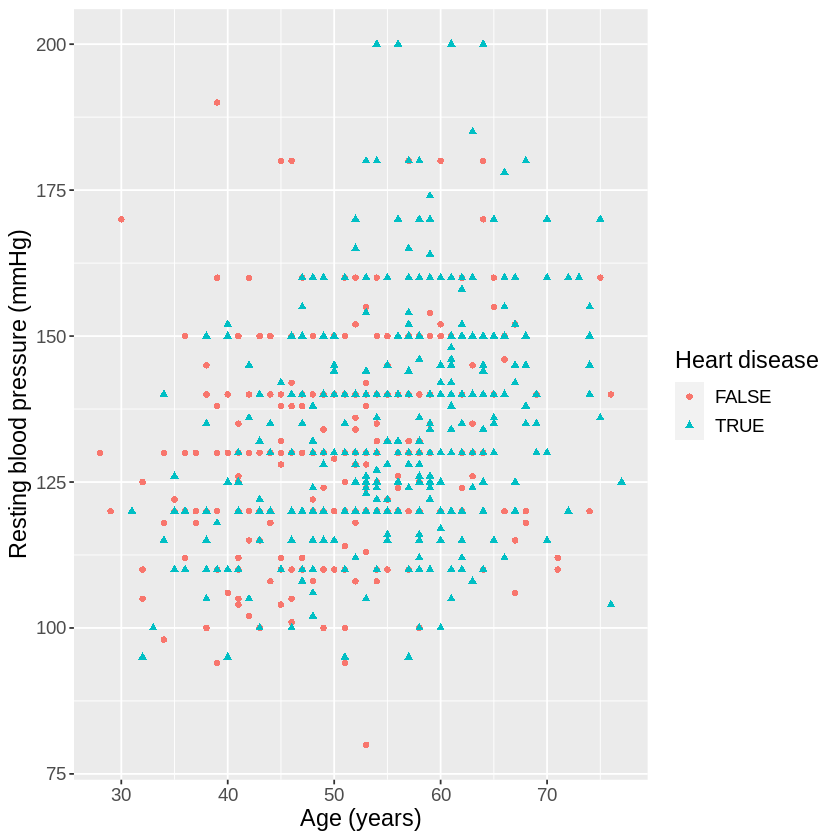

In [5]:
# Initial visualizations
pressure_vs_age <- heart_training |>
    ggplot(aes(x = age, y = trestbps, colour = disease, shape = disease)) +
        geom_point() +
        labs(x = "Age (years)", y = "Resting blood pressure (mmHg)", colour = "Heart disease", shape = "Heart disease") +
        theme(text = element_text(size = 14))
pressure_vs_age

## Methods (Paul)

## Expected outcomes and significance (Danyal)

From the data analysis being done, we intend to create a system that can accurately predict heart disease in a patient given their health conditions. Our code uses all the health conditions as inputs and then uses classification in R to make a prediction. We expect to find our predictor classifying patients with poor health conditions such as older age and high cholesterol to have higher chances of heart disease. Such findings would have a monumental effect on healthcare systems. It would allow medical workers to have an accurate predictor of heart disease in a number of patients. With this knowledge, preventive care can be administered and heart disease can be tackled before it sets in. Patients with higher chances can be monitored closely. This system could lead to questions such as ‘what are the chances of the predictor having anomalous results?’ Due to the nature of healthcare, such systems are always under enormous scrutiny. More questions that could be asked could be related to adapting this system for diseases other than heart disease. 

Footnotes

[1]https://www.cdc.gov/heartdisease/about.htm#:~:text=The%20term%20%E2%80%9Cheart%20disease%E2%80%9D%20refers,can%20cause%20a%20heart%20attack.
[2] https://www.mayoclinic.org/diseases-conditions/coronary-artery-disease/symptoms-causes/syc-20350613#:~:text=Signs%20and%20symptoms%20of%20coronary,can%20cause%20a%20heart%20attack.